In [21]:
from nnfs.datasets import spiral_data
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import shutil
import os
sns.set()

In [22]:
# X, y = make_circles(10000, noise=.03, random_state=43)
X, y = spiral_data(samples=5000, classes=2)

In [23]:
X.shape, y.shape

((10000, 2), (10000,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=.2,
    random_state=42
)

X_train.shape, y_train.shape

((8000, 2), (8000,))

In [25]:
df = pd.DataFrame(np.append(X, y.reshape(-1, 1), axis=1), columns=['X1', 'X2', 'y'])
df

,X1,X2,y
0,0.000000,0.000000,0.0
1,-0.000087,0.000180,0.0
2,-0.000074,0.000393,0.0
3,-0.000155,0.000580,0.0
4,0.000339,0.000725,0.0
...,...,...,...
9995,0.746675,-0.663985,1.0
9996,0.744151,0.667113,1.0
9997,0.854578,0.518552,1.0
9998,0.633681,0.773336,1.0


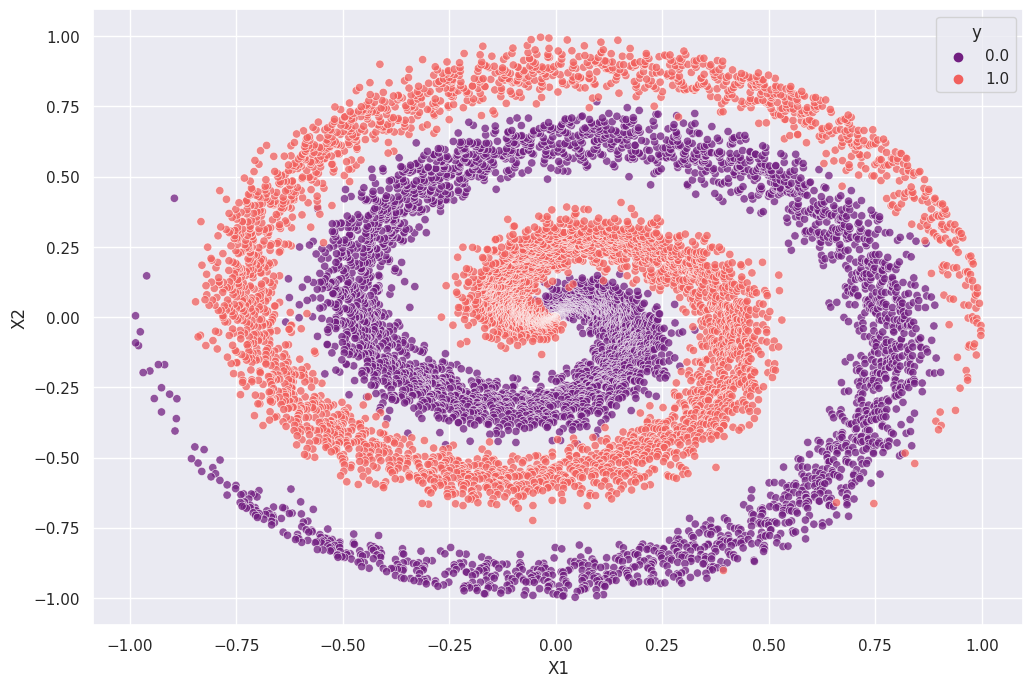

In [26]:
pallete = {
  0: 'tab:red',
  1: 'tab:green',
  2: 'tab:blue'
}

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='X1', y='X2', hue='y', palette='magma', alpha=.75)
plt.show()

In [27]:
class StoreContent:
  def __init__(self, name_dir):
    self.name_dir = name_dir
    self.pwd = os.getcwd()

  def delete_dir(self):
    if os.path.isdir(self.name_dir):
      shutil.rmtree(self.name_dir)
    else:
      print('folder telah dihapus')

  def store_data(self, data, separate=False, second_dir={}):
    '''
    paramater data harus merupakan dictionary, misal data={nama_file:nilai_data}
    '''
    
    dir_name = os.path.join(self.pwd, self.name_dir)

    if separate:
      for folder_names, values in second_dir.items():
        if not os.path.isdir(f'{dir_name}/{folder_names}'):
          os.makedirs(f'{dir_name}/{folder_names}')
        
        np.save(f'{dir_name}/{folder_names}/epoch_{data}.npy', values)
    
    else:
      assert type(data) == dict, 'nilai data harus bertipe dictionary'
      if not os.path.isdir(self.name_dir):
        os.mkdir(dir_name)
      for filename, value in data.items():
        np.save(f'{dir_name}/{filename}.npy', value)


class PerformancePlotCallback(StoreContent, keras.callbacks.Callback):
    def __init__(self, name_dir, x, y):
      super().__init__(name_dir)
      self.x = x
      self.y = y

        
    def on_epoch_end(self, epoch, logs=None):
        x_min, x_max = self.x[:, 0].min() - 0.1, self.x[:, 0].max() + 0.1
        y_min, y_max = self.x[:, 1].min() - 0.1, self.x[:, 1].max() + 0.1
        xx, yy = np.meshgrid(
          np.linspace(x_min, x_max, 100),
          np.linspace(y_min, y_max, 100)
        )

        x_in = np.c_[xx.ravel(), yy.ravel()]
        
        y_pred = self.model.predict(x_in)

        if len(y_pred[0]) > 1:
          y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
        else:
          y_pred = np.round(y_pred).reshape(xx.shape)
        
        self.store_data(
          epoch, 
          separate=True, 
          second_dir={
            'loss_history': logs['loss'], 
            'accuracy': logs['accuracy'], 
            'prediction_history': y_pred
          })
        
        # JIKA KASUS REGRESI
        '''
          # df = pd.DataFrame()
          # series = pd.Series(y_pred.ravel())
          # df[epoch] = series
          # df.to_csv(f'../datasets/training/epoch_{epoch}.csv')
        '''

def plot_decision_boundary(model, X, y):
    np.random.seed(43)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )
    
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)

    if len(y_pred[0]) > 1:
      y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
      y_pred = np.round(y_pred).reshape(xx.shape)

    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='white', linewidths=.05)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()


# 'Datasets_Classification'

In [28]:
create_container = StoreContent('data_source')
create_container.delete_dir()
create_container.store_data({
    'X':X, 
    'y':y, 
    'X_train':X_train, 
    'y_train':y_train,
    'X_test':X_test,
    'y_test':y_test
})

In [41]:
checkpoint = keras.callbacks.ModelCheckpoint("../models/spiral_data.h5", save_best_only=True)
performance = PerformancePlotCallback('history', x=X, y=y)

# performance.delete_dir()
model = keras.Sequential([
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
  loss=keras.losses.BinaryCrossentropy(),
  optimizer=keras.optimizers.Adam(),
  metrics=['accuracy']
)

history = model.fit(
  X_train, 
  y_train, 
  epochs=60, 
  verbose=1,
  callbacks=[checkpoint, performance],
  # batch_size=32,
)

Epoch 1/60
250/250 [==============================] - 1s 2ms/step - loss: 0.6727 - accuracy: 0.6035
Epoch 2/60
250/250 [==============================] - 1s 4ms/step - loss: 0.6624 - accuracy: 0.6200
Epoch 3/60
250/250 [==============================] - 1s 3ms/step - loss: 0.6593 - accuracy: 0.6210
Epoch 4/60
250/250 [==============================] - 1s 3ms/step - loss: 0.6530 - accuracy: 0.6240
Epoch 5/60
250/250 [==============================] - 1s 3ms/step - loss: 0.6404 - accuracy: 0.6298
Epoch 6/60
250/250 [==============================] - 1s 2ms/step - loss: 0.6149 - accuracy: 0.6361
Epoch 7/60
250/250 [==============================] - 1s 2ms/step - loss: 0.5746 - accuracy: 0.6643
Epoch 8/60
250/250 [==============================] - 1s 2ms/step - loss: 0.5175 - accuracy: 0.7544
Epoch 9/60
250/250 [==============================] - 1s 2ms/step - loss: 0.4434 - accuracy: 0.8510
Epoch 10/60
250/250 [==============================] - 1s 2ms/step - loss: 0.3662 - accuracy: 0.9120

In [42]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.0452 - accuracy: 0.9890


[0.04521135240793228, 0.9890000224113464]

313/313 [==============================] - 0s 635us/step


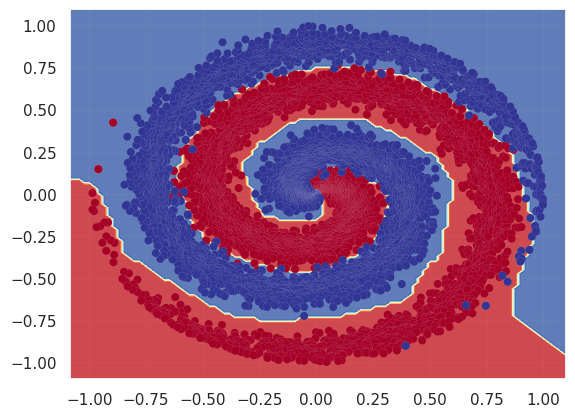

In [43]:
plot_decision_boundary(model, X, y)

63/63 [==============================] - 0s 659us/step


variable,y pred,y test
value,,
0.0,1001,1012
1.0,999,988


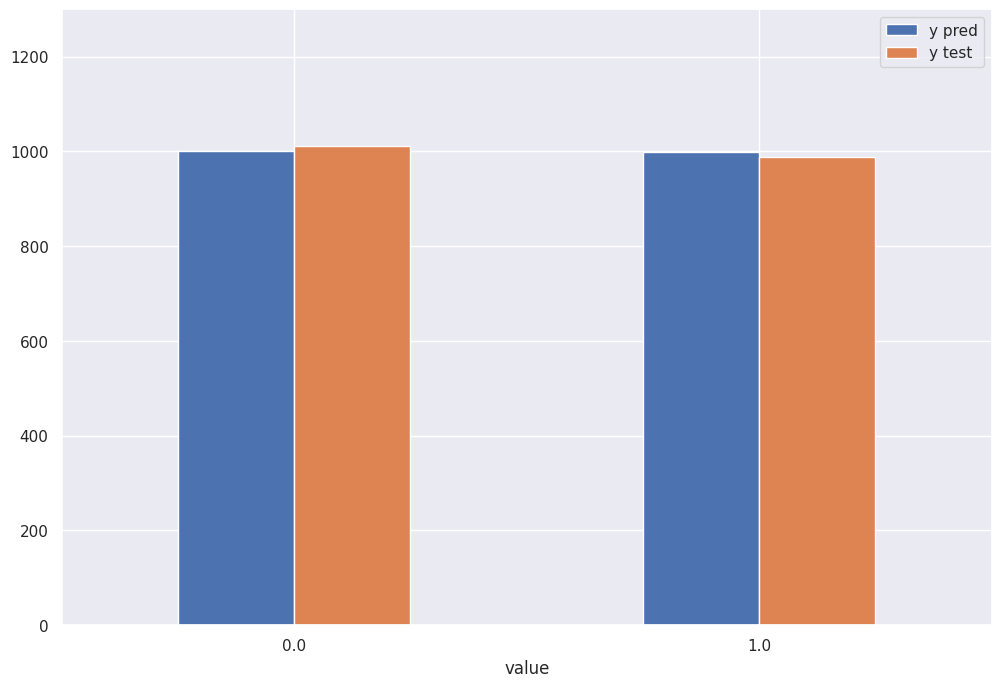

In [32]:

y_pred = np.round(model.predict(X_test))

df_compare = pd.DataFrame(np.c_[y_pred, y_test], columns=['y pred', 'y test'])

zero, one = df_compare['y pred'].value_counts()

# ax = sns.countplot(df_compare['y pred'])

# ax.annotate(
#     f'{zero}', 
#     xy=(0, zero), 
#     xytext=(0, zero + int(zero/8)), 
#     fontsize=12,
#     arrowprops=dict(facecolor='black', shrink=0.001)
# )

# ax.annotate(
#     f'{one}', 
#     xy=(1, one), 
#     xytext=(1, one + int(one/8)), 
#     fontsize=12,
#     arrowprops=dict(facecolor='black', shrink=0.001)
# )

# sns.catplot(data=df_compare.melt(), x='value', col='variable', kind='count', palette='magma_r')

df_plot = df_compare.melt().value_counts().sort_index()
display(df_plot.unstack('variable'))


df_plot.unstack('variable').plot.bar(rot=0, figsize=(12, 8))
plt.legend(loc='upper right')
plt.ylim([0, 1300])

plt.show()

<AxesSubplot:>

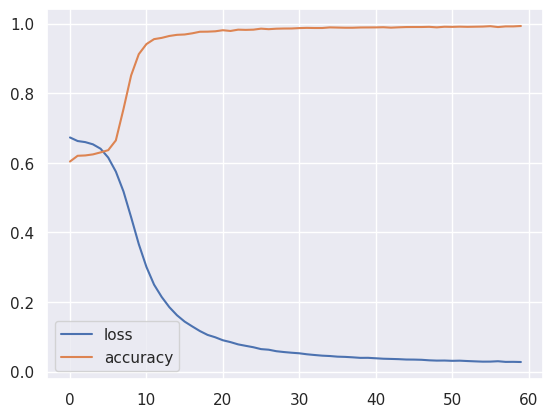

In [45]:
pd.DataFrame(history.history).plot()